In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


In [2]:
predictions = pd.read_csv('res/eta_per_cause_EFS_tuned_Combined.csv', index_col=0)
survival_data = pd.read_csv('clinical.csv', index_col=0)
labels = pd.read_pickle('labels_final.pkl')['Reviewed.subtype']
#labels = pd.read_csv('./input_data/from_survival/merged_data.csv', index_col=0, header=[   0, 1])
#labels = labels.subtype[labels.subtype.columns[:17]]
#labels = labels.idxmax(axis=1)
predictions.columns = [i.split('_')[-1] for i in predictions.columns]
# 1. Align and Sort Data
# Ensure we only use samples present in both datasets
common_idx = predictions.index.intersection(labels.index)
plot_preds = predictions.loc[common_idx]
plot_labels = labels.loc[common_idx]

# Fix Greek characters for LaTeX rendering
plot_labels = plot_labels.str.replace('γ', r'$\gamma$', regex=False)\
                         .str.replace('δ', r'$\delta$', regex=False)\
                         .str.replace('α', r'$\alpha$', regex=False)\
                         .str.replace('β', r'$\beta$', regex=False)

# Sort by subtype AND then by risk_Relapse within subtype
# Create a temporary dataframe for sorting
sort_df = pd.DataFrame({'subtype': plot_labels, 'Relapse': plot_preds['Relapse']})
sorted_idx = sort_df.sort_values(by=['subtype', 'Relapse'], ascending=[True, False]).index
plot_preds = plot_preds.loc[sorted_idx]
plot_labels = plot_labels.loc[sorted_idx]

In [3]:
def compute_at_risk(durations, group_mask, time_points):
    """
    Returns number at risk at each time point.
    """
    return [
        np.sum(durations[group_mask] >= t)
        for t in time_points
    ]

def add_risk_table(ax, time_points, n_low, n_high, fontsize=9):
    """
    Adds a number-at-risk table below an axis.
    """
    # Create a new axis below the CIF plot
    fig = ax.figure
    pos = ax.get_position()
    
    table_height = 0.08
    table_ax = fig.add_axes([
        pos.x0,
        pos.y0 - table_height,
        pos.width,
        table_height
    ])
    
    table_ax.axis("off")
    
    # Column positions
    x_positions = np.linspace(0.1, 0.9, len(time_points))
    
    # Header
    for x, t in zip(x_positions, time_points):
        table_ax.text(x, 0.85, f"{int(t/365)}y",
                      ha='center', va='center', fontsize=fontsize)
    
    # Rows
    table_ax.text(0.02, 0.45, "Low risk", ha='left', fontsize=fontsize)
    table_ax.text(0.02, 0.05, "High risk", ha='left', fontsize=fontsize)
    
    for x, nl, nh in zip(x_positions, n_low, n_high):
        table_ax.text(x, 0.45, str(nl), ha='center', fontsize=fontsize)
        table_ax.text(x, 0.05, str(nh), ha='center', fontsize=fontsize)


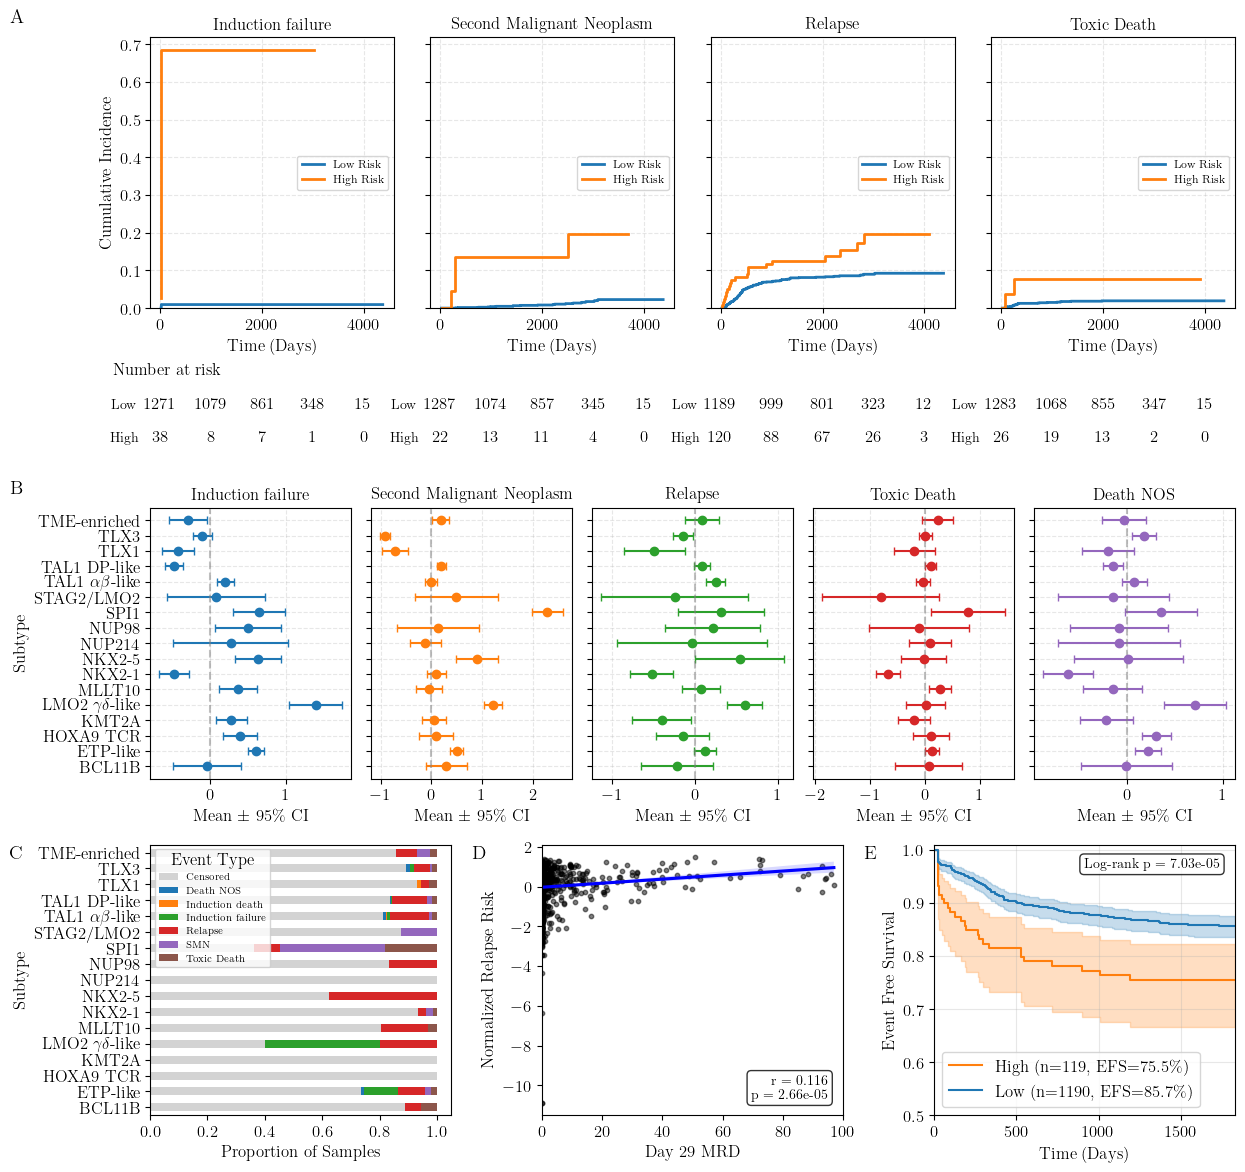

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sksurv.nonparametric import kaplan_meier_estimator, cumulative_incidence_competing_risks

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# === Load all data ===
predictions = pd.read_csv('res/eta_per_cause_EFS_tuned_Combined.csv', index_col=0)
survival_data = pd.read_csv('clinical.csv', index_col=0)
labels = pd.read_pickle('labels_final.pkl')['Reviewed.subtype']
predictions.columns = [i.split('_')[-1] for i in predictions.columns]

common_idx = predictions.index.intersection(labels.index)
plot_preds = predictions.loc[common_idx]
plot_labels = labels.loc[common_idx]

plot_labels = plot_labels.str.replace('γ', r'$\gamma$', regex=False)\
                         .str.replace('δ', r'$\delta$', regex=False)\
                         .str.replace('α', r'$\alpha$', regex=False)\
                         .str.replace('β', r'$\beta$', regex=False)\
                            .str.replace('&', r'\&', regex=False)

sort_df = pd.DataFrame({'subtype': plot_labels, 'Relapse': plot_preds['Relapse']})
sorted_idx = sort_df.sort_values(by=['subtype', 'Relapse'], ascending=[True, False]).index
plot_preds = plot_preds.loc[sorted_idx]
plot_labels = plot_labels.loc[sorted_idx]

# === Define CIF plotting function ===
def plot_cumulative_incidence_stratified2(durations, event_types, risk_scores, cause_idx, cause_name, ax=None):
    """
    Plots the TRUE Cumulative Incidence for High vs Low risk groups using competing risks framework.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        
    # 1. Define Groups
    event_count = np.sum(event_types == cause_idx)
    risk_cutoff_percentile = 100 - (event_count / len(event_types)) * 100
    median_risk = np.percentile(risk_scores, risk_cutoff_percentile)
    high_risk_mask = risk_scores >= median_risk
    # Time points (match journal standards)
    time_points = np.array([0, 365, 730, 1095, 1825])  # 0–5 years

    # Numbers at risk
    #n_low = compute_at_risk(durations, ~high_risk_mask, time_points)
    #n_high = compute_at_risk(durations, high_risk_mask, time_points)
    #print(time_points, n_low, n_high)

    # Draw risk table
    #add_risk_table(ax, time_points, n_low, n_high)
    
    # 2. Prepare data for Low Risk Group
    event_type_lo = event_types[~high_risk_mask].copy()
    durations_lo = durations[~high_risk_mask]
    
    # 3. Prepare data for High Risk Group  
    event_type_hi = event_types[high_risk_mask].copy()
    durations_hi = durations[high_risk_mask]
    
    # Helper function to remap events to consecutive integers
    def remap_events(events, target_cause):
        """Remap event types to consecutive integers, tracking target cause"""
        unique_events = np.unique(events[events > 0])
        if len(unique_events) == 0:
            return events, None
        
        event_map = {old: new for new, old in enumerate(unique_events, start=1)}
        remapped = events.copy()
        for old_val, new_val in event_map.items():
            remapped[events == old_val] = new_val
        
        # Find new index for target cause
        target_new_idx = event_map.get(target_cause, None)
        return remapped, target_new_idx
    
    # Remap events
    event_type_lo_remapped, target_idx_lo = remap_events(event_type_lo, cause_idx)
    event_type_hi_remapped, target_idx_hi = remap_events(event_type_hi, cause_idx)
    
    # Check if target cause exists in both groups
    if target_idx_lo is None or target_idx_hi is None:
        ax.text(0.5, 0.5, f'Event type {cause_name} not present\nin one or both risk groups', 
                ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set_title(f"{cause_name}", fontsize=12, fontweight='bold')
        return ax
    
    try:
        # 4. Calculate CIF - Low Risk
        time_lo, cum_inc_lo = cumulative_incidence_competing_risks(
            event_type_lo_remapped,
            durations_lo
        )
        prob_lo = cum_inc_lo[target_idx_lo, :]
        ax.step(time_lo, prob_lo, where="post", label="Low Risk", color='#1f77b4', lw=2)
        
        # 5. Calculate CIF - High Risk
        time_hi, cum_inc_hi = cumulative_incidence_competing_risks(
            event_type_hi_remapped,
            durations_hi
        )
        prob_hi = cum_inc_hi[target_idx_hi, :]
        ax.step(time_hi, prob_hi, where="post", label="High Risk", color='#ff7f0e', lw=2)
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=9)
    
    # Formatting
    ax.set_title(f"{cause_name}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (Days)")
    ax.set_ylabel("Cumulative Incidence")
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc="center right", fontsize=8)
    
    return ax

# === Create Figure ===
fig = plt.figure(figsize=(14, 14))
gs_main = gridspec.GridSpec(
    4, 1,
    height_ratios=[1.0, 0.25, 1.0, 1.0],
    hspace=0.3
)

gs_cif = gridspec.GridSpecFromSubplotSpec(
    1, 4, subplot_spec=gs_main[0], wspace=0.15
)

gs_tables = gridspec.GridSpecFromSubplotSpec(
    1, 4, subplot_spec=gs_main[1], wspace=0.15
)


# Row 0: Panel A - Cumulative Incidence (5 subplots)
#gs_row0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_main[0], wspace=0.1)

# Row 1: Panel B - Forest plot (5 subplots)
gs_row1 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs_main[2], wspace=0.1)

# Row 2: Panels C, D, E
gs_row2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_main[3], wspace=0.3)

# === Panel A: Cumulative Incidence (True CIF) ===
df_clin = pd.read_csv('clinical.csv', index_col=0)
eta_preds = pd.read_csv('res/eta_per_cause_EFS_tuned_Combined.csv', index_col=0)
annotations = pd.read_csv('annotations.csv', index_col=0)

annotations['Event.Type'] = annotations['Event.Type'].replace({'Induction death': 'Death NOS'})
annotations = annotations.fillna({'Event.Type': 'Censored'})

et_to_idx = {"Censored":0, "Relapse":1, "Toxic Death":2, "Induction failure":3, "Second Malignant Neoplasm":4, "Death NOS":5}
event_types = annotations['Event.Type'].map(et_to_idx)

common_idx_a = df_clin.index.intersection(event_types.index).intersection(eta_preds.index)
common_idx_a = list(common_idx_a)
eta_preds = eta_preds.loc[common_idx_a]
df_clin_a = df_clin.loc[common_idx_a]
event_types = event_types.loc[common_idx_a]
durations = df_clin_a['EFS_days'].values
event_type = event_types.values

#causes_list = ['Relapse', 'Toxic Death', 'Induction failure', 'SMN', 'Death NOS']
#cause_map = {'Relapse': 1, 'Toxic Death': 2, 'Induction failure': 3, 'SMN': 4, 'Death NOS': 5}
causes_list = [ 'Induction failure', 'Second Malignant Neoplasm', 'Relapse', 'Toxic Death']
cause_map = {'Relapse': 1, 'Toxic Death': 2, 'Induction failure': 3, 'Second Malignant Neoplasm': 4, 'Death NOS': 5}

# Store axes for Panel A to share y-axis
panel_a_axes = []
#causes_list = ['Relapse',  'Induction failure', 'Second Malignant Neoplasm']
for i, cause_name in enumerate(causes_list):

    ax = fig.add_subplot(gs_cif[i])
    panel_a_axes.append(ax)
    cause_idx = cause_map[cause_name]
    risk_scores_k = eta_preds.values[:, cause_idx-1]
    
    plot_cumulative_incidence_stratified2(
        durations, 
        event_type,
        risk_scores_k, 
        cause_idx, 
        cause_name, 
        ax=ax)
    
    if i > 0:
        ax.set_ylabel("")
        ax.tick_params(axis='y', labelleft=False)

# Get the maximum y-value across all Panel A subplots and set shared limits
y_max = max(ax.get_ylim()[1] for ax in panel_a_axes)
y_max = min(y_max, 1)  # Cap at 0.35 for
for ax in panel_a_axes:
    ax.set_ylim(0, y_max)

#ax.set_title('A', fontsize=14, fontweight='bold', x=0.02, y=0.97, va='top', ha='left')

#panel_a_axes[0].text(-0.05, y_max + 0.05, 'A', fontweight='bold', fontsize=14, va='top', ha='left')
pos = panel_a_axes[0].get_position()
x_pos_label = pos.x0 - 0.1
fig.text(x_pos_label, pos.y1 + 0.02, 'A', fontweight='bold', fontsize=14, va='top', ha='left')

# === Panel B: Forest Plot ===
events = plot_preds.columns.tolist()
events = ['Induction failure', 'Second Malignant Neoplasm', 'Relapse', 'Toxic Death', 'Death NOS']
forest_data = []

for subtype in sorted(plot_labels.unique()):
    mask = plot_labels == subtype
    for event in events:
        scores = plot_preds.loc[mask, event]
        normalized = (scores - plot_preds[event].mean()) / plot_preds[event].std()
        forest_data.append({
            'Subtype': subtype,
            'Event': event,
            'Mean': normalized.mean(),
            'CI_low': normalized.mean() - 1.96 * normalized.std() / np.sqrt(len(normalized)),
            'CI_high': normalized.mean() + 1.96 * normalized.std() / np.sqrt(len(normalized))
        })

forest_df = pd.DataFrame(forest_data)
subtypes_sorted = sorted(plot_labels.unique())
colors = sns.color_palette('tab10', len(events))

###############Tables
time_points = np.array([0, 1000, 2000, 3000, 4000])

for i, ax in enumerate(panel_a_axes):

    ax_t = fig.add_subplot(gs_tables[i], sharex=panel_a_axes[i])

    ax_t.set_ylim(0, 1)
    ax_t.set_yticks([])
    ax_t.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    ax_t.tick_params(axis='x', bottom=False, labelbottom=False)
    table_ax = ax_t 

    # Use the SAME risk split used for that CIF
    risk_scores = eta_preds.values[:, cause_map[causes_list[i]] - 1]
    event_count = np.sum(event_type == cause_map[causes_list[i]])
    cutoff = np.percentile(
        risk_scores,
        100 - (event_count / len(event_type)) * 100
    )
    high_risk = risk_scores >= cutoff

    n_low = [np.sum(durations[~high_risk] >= t) for t in time_points]
    n_high = [np.sum(durations[high_risk] >= t) for t in time_points]

    # Header
    x = np.linspace(0.15, 0.95, len(time_points))
    #for xi, t in zip(x, time_points):
    #    table_ax.text(xi, 0.75, f"{int(t/365)}y",
    #                  ha='center', fontsize=9)

    # Rows
    #table_ax.text(0.02, 0.40, "Low", fontsize=9)
    #table_ax.text(0.02, 0.05, "High", fontsize=9)
    if i == 0:
        ax_t.text(-0.15, 1, "Number at risk", fontsize=12, fontweight='bold', transform=ax_t.transAxes)
        
    #for t in time_points:
    #    ax_t.text(t, 0.75, f"{int(t/365)}y",
    #            ha='center', va='center', fontsize=9)

    # Row labels (x in axes coords, y in data coords)
    ax_t.text(
        -0.16, 0.50, "Low",
        transform=ax_t.transAxes, fontsize=10
    )
    ax_t.text(
        -0.165, 0.0, "High",
        transform=ax_t.transAxes, fontsize=10
    )

    # Numbers at risk (x in data coords!)
    for t, lo, hi in zip(time_points, n_low, n_high):
        ax_t.text(t, 0.50, lo, ha='center', fontsize=12)
        ax_t.text(t, 0.0, hi, ha='center', fontsize=12)
###############

panel_b_axes = []
for ax_idx, event in enumerate(events):
    
    ax = fig.add_subplot(gs_row1[ax_idx])
    panel_b_axes.append(ax)
    
    for y, subtype in enumerate(subtypes_sorted):
        row = forest_df[(forest_df['Subtype'] == subtype) & (forest_df['Event'] == event)].iloc[0]
        ax.errorbar(row['Mean'], y, 
                    xerr=[[row['Mean'] - row['CI_low']], [row['CI_high'] - row['Mean']]], 
                    fmt='o', color=colors[ax_idx], capsize=3)
    
    ax.axvline(0, color='grey', linestyle='--', alpha=0.5)
    ax.set_title(event, fontsize=12, fontweight='bold')
    ax.set_xlabel(r'Mean $\pm$ 95\% CI')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    if ax_idx == 0:
        ax.set_yticks(range(len(subtypes_sorted)))
        ax.set_yticklabels(subtypes_sorted, fontsize=12)
        ax.set_ylabel('Subtype')
    else:
        ax.set_yticks(range(len(subtypes_sorted)))
        ax.set_yticklabels([])

pos = panel_b_axes[0].get_position()
fig.text(x_pos_label, pos.y1 + 0.02, 'B', fontweight='bold', fontsize=14, va='top', ha='left')
#fig.text(0.02, 0.64, 'B', fontweight='bold', fontsize=14, va='top', ha='left')

# === Panel C: Event Type Distribution ===
ax_c = fig.add_subplot(gs_row2[0])

annotations_c = pd.read_csv('annotations.csv', index_col=0)
event_type_c = annotations_c['Event.Type']
labels_events = pd.DataFrame(plot_labels).rename(columns={'Reviewed.subtype': 'Subtype'}).join(event_type_c, how='inner').rename(columns={'Event.Type': 'EventType'}).fillna('No Event')
event_counts = pd.crosstab(labels_events['Subtype'], labels_events['EventType'])
event_props = event_counts.div(event_counts.sum(1), axis=0)

if 'No Event' in event_props.columns:
    cols = ['No Event'] + [c for c in event_props.columns if c != 'No Event']
    event_props = event_props[cols]
    colors_c = ['lightgrey'] + list(sns.color_palette('tab10', n_colors=len(cols)-1))
else:
    colors_c = sns.color_palette('tab10', n_colors=len(event_props.columns))

event_props.plot(kind='barh', stacked=True, ax=ax_c, color=colors_c, legend=False)
ax_c.set_xlabel('Proportion of Samples')
ax_c.set_ylabel('Subtype')
legend_labels = ax_c.get_legend_handles_labels()
legend_labels = (legend_labels[0], [lbl.replace('No Event', 'Censored').replace('Second Malignant Neoplasm', 'SMN') for lbl in legend_labels[1]])
ax_c.legend(legend_labels[0], legend_labels[1], title='Event Type',bbox_to_anchor=(0, 1), loc='upper left', ncol=1, fontsize=7)

pos = ax_c.get_position()
y_pos_bottom = pos.y1 
fig.text(x_pos_label, y_pos_bottom, 'C', fontweight='bold', fontsize=14, va='top', ha='left')

# === Panel D: Regression Plot ===
ax_d = fig.add_subplot(gs_row2[1])

cns = pd.read_csv('annotations.csv', index_col=0, header=0)
mrd = cns['Day.29.MRD']
relapse_data = plot_preds[['Relapse']].copy()
center_relapse_data = (relapse_data['Relapse'] - relapse_data['Relapse'].mean()) / relapse_data['Relapse'].std()
relapse_data['Normalized Relapse'] = center_relapse_data
relapse_data = relapse_data.join(pd.DataFrame(mrd), how='inner')

clean_data = relapse_data[['Day.29.MRD', 'Normalized Relapse']].dropna()
r, p_value = stats.pearsonr(clean_data['Day.29.MRD'], clean_data['Normalized Relapse'])

sns.regplot(data=relapse_data, x='Day.29.MRD', y='Normalized Relapse', 
            scatter_kws={'s':10, 'color':'black', 'alpha':0.5}, 
            line_kws={'color':'blue'}, ax=ax_d)

p_text = f'r = {r:.3f}\np = {p_value:.2e}' if p_value < 0.001 else f'r = {r:.3f}\np = {p_value:.3f}'
ax_d.text(0.95, 0.15, p_text, transform=ax_d.transAxes, fontsize=10, 
          verticalalignment='top', horizontalalignment='right',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax_d.set_xlabel('Day 29 MRD')
ax_d.set_ylabel('Normalized Relapse Risk')
ax_d.set_xlim(0, 100)

pos = ax_d.get_position()
x_pos_d = pos.x0 - 0.05

fig.text(x_pos_d, y_pos_bottom, 'D', fontweight='bold', fontsize=14, va='top', ha='left')

# === Panel E: Kaplan-Meier ===
ax_e = fig.add_subplot(gs_row2[2])

etas = pd.read_csv('res/eta_per_cause_EFS_tuned_Combined.csv', index_col=0)
df = pd.read_csv('clinical.csv', index_col=0)
df_plot = etas.join(df, how='inner')

split = 11
df_plot['relapse_deciles'] = pd.qcut(df_plot['eta_cause_Relapse'], split, labels=[i for i in range(split)])
df_plot['relapse_deciles'] = ['High' if i == split - 1 else 'Low' for i in df_plot['relapse_deciles']]

kmf = KaplanMeierFitter()
max_time = 365 * 5
surv_col = 'EFS_days'
surv_status = 'EFS_status'

high_risk = low_risk = None
for name, group in df_plot.groupby('relapse_deciles', observed=True):
    durations_km = np.minimum(group[surv_col], max_time)
    events_km = np.where(group[surv_col] <= max_time, group[surv_status], 0)
    kmf.fit(durations=durations_km, event_observed=events_km)
    
    n = len(group)
    final_s = kmf.survival_function_.iloc[-1, 0]
    label = f"{name} (n={n}, EFS={final_s * 100:.1f}\%)"
    
    color = '#ff7f0e' if name == 'High' else '#1f77b4'
    kmf.plot_survival_function(label=label, ci_show=True, color=color, ax=ax_e)
    
    if name == 'High':
        high_risk = group
    else:
        low_risk = group

results = logrank_test(high_risk[surv_col], low_risk[surv_col],
                       event_observed_A=high_risk[surv_status], 
                       event_observed_B=low_risk[surv_status])
p_text = f'Log-rank p = {results.p_value:.2e}' if results.p_value < 0.001 else f'Log-rank p = {results.p_value:.3f}'
ax_e.text(0.95, 0.95, p_text, transform=ax_e.transAxes, fontsize=10,
          verticalalignment='top', horizontalalignment='right',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax_e.set_xlabel('Time (Days)')
ax_e.set_ylabel('Event Free Survival')
ax_e.set_ylim(0.5, 1.01)
ax_e.set_xlim(0, max_time)
ax_e.grid(alpha=0.3)

pos = ax_e.get_position()
x_pos_e = pos.x0 - 0.05
fig.text(x_pos_e, y_pos_bottom, 'E', fontweight='bold', fontsize=14, va='top', ha='left')

plt.savefig('Multipanel_figure2.pdf', dpi=600, bbox_inches='tight')
plt.show()